In [1]:
# Basic system libraries
import os.path
import glob
import tempfile
from io import BytesIO
import re
from collections import Counter

# Additional libraries for web, archives and parallel execution
import requests
import json
import tarfile
import tqdm
from joblib import Parallel, delayed

# Basic scientific staff
import numpy as np
import pandas as pd

# Libraries for visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import matplotlib.ticker

# Library for 3D structures
import prody

In [2]:
# Set species ID
specid = 9606  # Homo sapiens
# specid = 10900  # Mus musculus
# specid = 7227  # Drosophila melanogaster
# specid = 6239  # Caenorhabditis elegans
# specid = 83333  # Escherichia coli

# Set path to the unarchived repository of the corresponding species
afdbpath = '/mnt/scratch/alphafold.ebi.ac.uk/homo_sapiens/'

In [3]:
# Read metadata from Uniprot

uurl = 'https://www.uniprot.org/uniprot/?query=reviewed:yes+AND+organism:%s&columns=id,entry name,reviewed,protein names,genes,organism,length,sequence,database(Pfam),feature(DOMAIN EXTENT)&format=tab' % specid
ureq = requests.get(uurl)
udata = pd.read_csv(BytesIO(ureq.content), delimiter='\t')

In [4]:
udata

,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Sequence,Cross-reference (Pfam),Domain [FT]
0,Q00266,METK1_HUMAN,reviewed,S-adenosylmethionine synthase isoform type-1 (...,MAT1A AMS1 MATA1,Homo sapiens (Human),395,MNGPVDGLCDHSLSEGVFMFTSESVGEGHPDKICDQISDAVLDAHL...,PF02773;PF02772;PF00438;,NaN
1,Q8NB16,MLKL_HUMAN,reviewed,Mixed lineage kinase domain-like protein (hMLKL),MLKL,Homo sapiens (Human),471,MENLKHIITLGQVIHKRCEEMKYCKKQCRRLGHRVLGLIKPLEMLQ...,PF07714;,"DOMAIN 194..469; /note=""Protein kinase""; /ev..."
2,O94851,MICA2_HUMAN,reviewed,[F-actin]-monooxygenase MICAL2 (EC 1.14.13.225...,MICAL2 KIAA0750 MICAL2PV1 MICAL2PV2,Homo sapiens (Human),1124,MGENEDEKQAQAGQVFENFVQASTCKGTLQAFNILTRHLDLDPLDH...,PF00307;PF01494;PF00412;,"DOMAIN 516..619; /note=""Calponin-homology (CH..."
3,Q8TDZ2,MICA1_HUMAN,reviewed,[F-actin]-monooxygenase MICAL1 (EC 1.14.13.225...,MICAL1 MICAL NICAL,Homo sapiens (Human),1067,MASPTSTNPAHAHFESFLQAQLCQDVLSSFQELCGALGLEPGGGLP...,PF00307;PF12130;PF01494;PF00412;,"DOMAIN 508..612; /note=""Calponin-homology (CH..."
4,Q9NPJ6,MED4_HUMAN,reviewed,Mediator of RNA polymerase II transcription su...,MED4 ARC36 DRIP36 VDRIP HSPC126,Homo sapiens (Human),270,MAASSSGEKEKERLGGGLGVAGGNSTRERLLSALEDLEVLSRELIE...,PF10018;,NaN
...,...,...,...,...,...,...,...,...,...,...
20381,Q9P2T1,GMPR2_HUMAN,reviewed,GMP reductase 2 (GMPR 2) (EC 1.7.1.7) (Guanosi...,GMPR2,Homo sapiens (Human),348,MPHIDNDVKLDFKDVLLRPKRSTLKSRSEVDLTRSFSFRNSKQTYS...,PF00478;,NaN
20382,Q8IUX8,EGFL6_HUMAN,reviewed,Epidermal growth factor-like protein 6 (EGF-li...,EGFL6 MAEG PP648 UNQ281/PRO320,Homo sapiens (Human),553,MPLPWSLALPLLLSWVAGGFGNAASARHHGLLASARQPGVCHYGTK...,PF07645;PF00629;,"DOMAIN 65..91; /note=""EGF-like 1""; /evidence..."
20383,O15372,EIF3H_HUMAN,reviewed,Eukaryotic translation initiation factor 3 sub...,EIF3H EIF3S3,Homo sapiens (Human),352,MASRKEGTGSTATSSSSTAGAAGKGKGKGGSGDSAVKQVQIDGLVV...,PF01398;,"DOMAIN 39..173; /note=""MPN""; /evidence=""ECO:..."
20384,P54852,EMP3_HUMAN,reviewed,Epithelial membrane protein 3 (EMP-3) (Hematop...,EMP3 YMP,Homo sapiens (Human),163,MSLLLLVVSALHILILILLFVATLDKSWWTLPGKESLNLWYDCTWN...,PF00822;,NaN


In [5]:
# Read metadata from SwissModel

smgz = "%d_meta.tar.gz" % specid

# Do everything in temp dir, which will be safely discarded later
with tempfile.TemporaryDirectory() as tmpdirname:
    
    # Download SwissModel repo metadata
    smreq = requests.get("https://swissmodel.expasy.org/repository/download/core_species/%s" % smgz)
    fname = os.path.join(tmpdirname, smgz)
    
    with open(fname, 'wb') as f:
        f.write(smreq.content)
    
    # Unpack key INDEX.json file
    with tarfile.open(fname, "r:gz") as f:
        f.extract('SWISS-MODEL_Repository/INDEX.json', path=tmpdirname)
    
    # Read INDEX.json as pandas dataframe
    fname = os.path.join(tmpdirname, 'SWISS-MODEL_Repository/INDEX.json')
    
    with open(fname, 'rb') as f:
        smdata_ = json.load(f)
        smdata__ = pd.DataFrame(smdata_['index'])
        
smdata = smdata__[~smdata__['uniprot_ac'].str.contains('-') & (smdata__['provider'] == 'SWISSMODEL')]

In [6]:
smdata

,uniprot_ac,iso_id,uniprot_seq_length,uniprot_seq_md5,coordinate_id,provider,from,to,template,qmean,qmean_norm,seqid,url
0,P31946,P31946-1,246,c82f2efd57f939ee3c4e571708dd31a8,60dd3e88174af46ef177faa5,SWISSMODEL,3,232,2c1j.1.A,-0.614406,0.749879,86.885246,https://swissmodel.expasy.org/repository/unipr...
15,Q04917,NaN,246,f0ca768e1872663333edabb95b42593f,60dd3e88174af46ef177fadb,SWISSMODEL,3,235,2c63.2.A,0.666539,0.790966,100.0,https://swissmodel.expasy.org/repository/unipr...
18,P62258,P62258-1,255,76c3a409540532138c6b44bde9e4d248,60dd239e043e69adfafc2f47,SWISSMODEL,3,232,2br9.1.B,0.064817,0.771514,100.0,https://swissmodel.expasy.org/repository/unipr...
25,P61981,NaN,247,af0ef9579977271fea3448c46f56f121,60dd3d34425c29f128507717,SWISSMODEL,3,235,2c63.2.A,0.633274,0.789906,86.991867,https://swissmodel.expasy.org/repository/unipr...
43,P31947,P31947-1,248,48e177d057c56e9a145fd9baf7409da9,60dd38766f5101b71f1ca82b,SWISSMODEL,1,231,3lw1.1.B,0.438789,0.7836,100.0,https://swissmodel.expasy.org/repository/unipr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159027,A0A494C0I6,NaN,67,15355dd80d600a220f814d7f7a67b4fb,60d7abbd5c8660f78d7cd785,SWISSMODEL,12,38,3wxe.1.A,-2.633932,0.450467,33.333332,https://swissmodel.expasy.org/repository/unipr...
159028,A0A1W2PQ27,NaN,194,9f85da359ae09e21b665505e4fb87f0f,60ddf40a1b0b23f04d39bf35,SWISSMODEL,3,194,3o2q.2.B,0.092774,0.784199,70.103096,https://swissmodel.expasy.org/repository/unipr...
159029,V9GZ13,NaN,50,b69128a3b74120471c78e4400dc47566,60d82e3b987eae8e555a704f,SWISSMODEL,5,31,4rvy.1.L,-3.357552,0.365089,33.333332,https://swissmodel.expasy.org/repository/unipr...
159030,A0A2R8Y4L6,NaN,323,0b2146901b74df9a9a8006c946762e4b,60dc5c0db85d6fa3719abd6f,SWISSMODEL,30,318,6tp3.1.A,-3.974456,0.61451,16.607775,https://swissmodel.expasy.org/repository/unipr...


In [8]:
# Read pLDDT scores from local database

afnames = glob.glob(os.path.join(afdbpath, '*.cif.gz'))

def extract_plddt_from_cif(fname):
    ac = os.path.basename(fname).split('-')[1]
    pdb, header = prody.parseMMCIF(fname, subset='ca', header=True)
    b = int(header[0].search('_ma_target_ref_db_details.seq_db_align_begin').data[0])
    e = int(header[0].search('_ma_target_ref_db_details.seq_db_align_end').data[0])
    plddt = pdb.getBetas()
    seq = pdb.getSequence()
    
    return((ac, b, e, plddt, seq))

# Use parallel processing to speedup things
plddt_all = Parallel(n_jobs=-1, verbose=1)(delayed(extract_plddt_from_cif)(fname) for fname in afnames)   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 994 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 2194 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 2944 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 3794 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 4744 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 5794 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 6944 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 8194 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 9544 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 10994 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 12544 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 14194 tasks  

In [9]:
afdata_ = dict()

for r in plddt_all:
    ac, b, e, plddt, seq = r
    
    if ac not in afdata_:
        afdata_[ac] = {
            'ac': ac,
            'frags': list()
        }
    
    afdata_[ac]['frags'].append((b, e, plddt, seq))
    
# Merge pLDDT for fragments
afdata__ = list()

for ac in afdata_.keys():
    
    # guess protein length only from unsorted records
    # this might not the optimal way, but the most generic one
    L = 0
    for frag in afdata_[ac]['frags']:
        b, e, plddt_, seq_ = frag
        L = max(L, e)
    
    # Create an array to store pLDDT scores
    plddt = np.zeros(L)
    seq = np.empty(L, dtype='U1')
    
    # Now select best pLDDT score per residue from all frags
    for frag in afdata_[ac]['frags']:
        b, e, plddt_, seq_ = frag
        plddt[b - 1: e] = np.maximum(plddt[b - 1:e], plddt_)
        seq[b - 1: e] = list(seq_)

    # Store as simple list for compatibility with pandas
    d_ = {
        'uniprot_ac': ac,
        'pLDDT': plddt,
        'length': len(plddt),
        'sequence': ''.join(seq)
    }
    afdata__.append(d_)
    
afdata = pd.DataFrame(afdata__)

In [10]:
afdata

,uniprot_ac,pLDDT,length,sequence
0,P13945,"[31.35, 30.37, 32.33, 36.4, 34.13, 32.4, 35.58...",408,MAPWPHENSSLAPWPDLPTLAPNTANTSGLPGVPWEAALAGALLAL...
1,P13984,"[37.52, 45.07, 54.02, 56.62, 67.51, 80.49, 84....",249,MAERGELDLTGAKQNTGVWLVKVPKYLSQQWAKASGRGEVGKLRIA...
2,P13985,"[53.72, 53.43, 61.12, 69.32, 60.93, 66.42, 61....",223,MRCAHAPAPRTRYPTRAPSGPRPPSRSQAQTPPRSVPRLRPRHRHP...
3,P13987,"[42.48, 52.11, 59.04, 59.48, 59.41, 65.54, 69....",128,MGIQGGSVLFGLLLVLAVFCHSGHSLQCYNCPNPTADCKTAVNCSS...
4,P13994,"[59.5, 80.25, 87.2, 84.22, 88.34, 86.77, 88.74...",396,MGERKGVNKYYPPDFNPEKHGSLNRYHNSHPLRERARKLSQGILII...
...,...,...,...,...
20499,Q9NYQ7,"[31.03, 32.49, 32.63, 32.49, 33.46, 45.94, 45....",3312,MMARRPPWRGLGGRSTPILLLLLLSLFPLSQEELGGGGHQGWDPGL...
20500,Q9Y6V0,"[42.07, 49.14, 60.61, 51.25, 49.74, 54.12, 51....",5142,MGNEASLEGEGLPEGLAAAAAAGGGASGAGSPSHTAIPAGMEADLS...
20501,Q9Y4D8,"[42.4, 43.37, 45.83, 46.94, 52.46, 52.81, 52.0...",3996,MPANHLPIGSTMSTVHLSSDGTYFYWIWSPASLNEKTPKGHSVFMD...
20502,Q9Y520,"[38.11, 44.5, 41.32, 47.75, 46.15, 41.39, 42.2...",2896,MSEKSGQSTKAKDGKKYATLSLFNTYKGKSLETQKTTARHGLQSLG...


In [11]:
uset = set(udata['Entry']) 
smset = set(smdata['uniprot_ac'])
afset = set(afdata['uniprot_ac'])

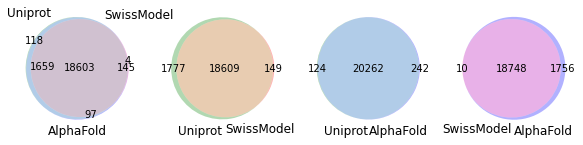

In [15]:
# All three sets
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
fig.set_size_inches((10, 10))

# Uniprot vs SwissModel vs AlphaFold
usmaf = venn3(
    [uset, smset, afset], 
    set_labels=('Uniprot', 'SwissModel', 'AlphaFold'), 
    set_colors=('g', 'r', 'b'),
    alpha=0.3,
    ax=ax0,
        )

# Uniprot vs SwissModel
usm = venn2(
    [uset, smset], 
    set_labels=('Uniprot', 'SwissModel'), 
    set_colors=('g', 'r'),
    alpha=0.3,
    ax=ax1
        )

# Uniprot vs AlphaFold
uaf = venn2(
    [uset, afset], 
    set_labels=('Uniprot', 'AlphaFold'), 
    set_colors=('g', 'b'),
    alpha=0.3,
    ax=ax2
        )

# Swissmodel vs AlphaFold
smaf = venn2(
    [smset, afset], 
    set_labels=('SwissModel', 'AlphaFold'), 
    set_colors=('r', 'b'),
    alpha=0.3,
    ax=ax3
        )

plt.show()

In [16]:
print('Intersection of Uniprot/SwissModel/AlphaFold: %s' % usmaf.get_label_by_id("111").get_text())
print('Intersection of SwissModel/AlphaFold: %s' % smaf.get_label_by_id("11").get_text())
print('New AlphaFold proteins (compared to SwissModel): %s' % smaf.get_label_by_id("01").get_text())

Intersection of Uniprot/SwissModel/AlphaFold: 18603
Intersection of SwissModel/AlphaFold: 18748
New AlphaFold proteins (compared to SwissModel): 1756


In [17]:
smuniq = (smset ^ afset) & smset
print('Proteins uniq for SwissModel (in comparison with AlphaFold): %d' % len(smuniq) )
for ac in smuniq:
    print(ac)

Proteins uniq for SwissModel (in comparison with AlphaFold): 10
C0HLV8
A0A7P0Z4L6
Q16881
A0A7P0TAN4
B0L3A2
Q9BQE4
A0A0G2JMZ2
A0A7P0T8H1
Q86VQ6
Q9NNW7


In [18]:
badids = list()

# Select common part of SwissModel and AlphaFold
tset1 = (smset & afset)

# Select new part of  AlphaFold
tset2 = (smset ^ afset) & afset

# Select only ACs from the reviewed Uniprot part
usmafcomp = list((tset1 | tset2) & uset)
smtotal = 0
newdata_ = list()

for ac in tqdm.tqdm(usmafcomp):
    # Extract reference length from Uniprot
    udata_ = udata[udata['Entry'] == ac]
    ul = udata_['Length'].values[0]
    useq = udata_['Sequence'].values[0]
    
    # There can be multiple models per AC
    smdata_ = smdata[smdata['uniprot_ac'] == ac]
    
    # Extract pLDDT
    afdata_ = afdata[afdata['uniprot_ac'] == ac]
    plddt = afdata_['pLDDT'].values[0]
    al = afdata_['length'].values[0]
    aseq = afdata_['sequence'].values[0]
    
    if ul != al:
        badids.append(ac)
        print('Found length mismatch: %s %d %d' % (ac, ul, al))
        continue
        
    if useq != aseq:
        badids.append(ac)
        print('Found seq mismatch: %s' % (ac))
        continue
        
    if len(smdata_) ==  0:
                
        d_ = {
            'uniprot_ac': ac,
            'fragnum': 0,
            'from': 1,
            'to': ul,
            'length': len(plddt),
            'pLDDT': plddt,
            'pLDDT_min': np.min(plddt_),
            'pLDDT_med': np.median(plddt_),
            'pLDDT_max': np.max(plddt_),
            'sequence': aseq,
        }
        
        newdata_.append(d_)
        
        # Since there is no SwissModel data
        # just switch to the next AC
        continue
    
    coverage = np.zeros(ul)
    breaks = list()

    for index, row in smdata_.iterrows():

        b = row['from']
        e = row['to']

        coverage[b - 1: e] = 1

    # Naive break search
    b_ = False
    bb_ = None
    be_ = None

    for i in range(ul):
        if coverage[i] == 0:
            if b_ is False:
                b_ = True
                # pdb starts with 1
                bb_ = i + 1 
            elif b_ is True:
                pass
        elif coverage[i] == 1 and b_ is True:
            be_ = i # already i + 1
            breaks.append((bb_, be_))
            b_ = False

    # Check the missing C-terminus
    if b_ is True:
        breaks.append((bb_, i + 1))
        b_ = False
        
    smtotal += np.sum(coverage)

    for i, b in enumerate(breaks):
        bb_, be_ = b
        plddt_ = plddt[bb_ - 1:be_]
        seq_ = aseq[bb_ - 1:be_]
        
        d_ = {
            'uniprot_ac': ac,
            'fragnum': i,
            'from': bb_,
            'to': be_,
            'length': len(plddt_),
            'pLDDT': plddt_,
            'pLDDT_min': np.min(plddt_),
            'pLDDT_med': np.median(plddt_),
            'pLDDT_max': np.max(plddt_),
            'sequence': seq_,
        }
        
        newdata_.append(d_)

newdata = pd.DataFrame(newdata_)

  5%|▍         | 938/20262 [00:07<02:31, 127.41it/s]

Found seq mismatch: P11586


 25%|██▌       | 5116/20262 [00:41<02:07, 118.77it/s]

Found length mismatch: Q9Y2G2 537 431


 30%|██▉       | 5993/20262 [00:48<01:57, 121.27it/s]

Found length mismatch: Q8WYJ6 372 367


 82%|████████▏ | 16551/20262 [02:15<00:33, 110.86it/s]

Found length mismatch: Q04741 290 257


100%|██████████| 20262/20262 [02:48<00:00, 120.09it/s]


In [19]:
newdata

,uniprot_ac,fragnum,from,to,length,pLDDT,pLDDT_min,pLDDT_med,pLDDT_max,sequence
0,Q13098,0,1,36,36,"[36.74, 37.93, 31.91, 36.59, 36.26, 34.79, 36....",31.91,38.725,87.71,MPLPVQVFNLQGAVEPMQIDVDPQEDPQNAPDVNYV
1,Q13098,1,470,491,22,"[65.72, 62.78, 52.45, 50.76, 44.17, 42.82, 42....",34.94,38.610,65.72,PREGSQGELTPANSQSRMSTNM
2,Q8WWM9,0,1,16,16,"[47.3, 57.67, 49.41, 64.97, 60.4, 58.9, 62.83,...",44.48,52.615,64.97,MEKVPGEMEIERRERS
3,Q8WWM9,1,189,190,2,"[48.91, 57.12]",48.91,53.015,57.12,GP
4,P0C866,0,1,244,244,"[32.73, 36.16, 38.87, 34.55, 38.12, 31.45, 27....",21.08,75.990,91.65,MLLSWGGGESRRPVQEASSATDTDTNSQEDPADTASVRSLSLSAGH...
...,...,...,...,...,...,...,...,...,...,...
37357,P48066,1,596,632,37,"[92.31, 90.08, 83.68, 76.25, 75.35, 63.56, 61....",26.75,32.210,92.31,MRGKLGVSPRMVTVNDCDAKLKSDGTIAAITEKETHF
37358,O95822,0,1,38,38,"[34.86, 29.86, 31.59, 32.97, 30.27, 38.2, 32.0...",29.86,37.185,92.35,MRGFGPGLTARRLLPLRLPPRPPGPRLASGQAAGALER
37359,Q9BRH9,0,1,158,158,"[38.12, 37.98, 33.83, 36.12, 32.87, 36.92, 35....",21.63,34.065,88.95,MAATFQLPGHQEMPLTFQDVAVYFSQAEGRQLGPQQRALYRDVMLE...
37360,Q9BRH9,1,650,671,22,"[36.69, 38.84, 36.48, 38.19, 35.39, 38.9, 39.5...",35.39,39.160,43.70,ALNDGSKRYFIHIKKIFQERHF


In [20]:
print('Total Unpritot size (proteins): %d' % len(udata))
ucompletel = np.sum(udata['Length'])
print('Total Unpritot size (aa): %d' % ucompletel)

smcomplete = smdata[(smdata['from'] == 1) & 
                    (smdata['to'] == smdata['uniprot_seq_length'])]
print('Complete models in SwissModel (proteins): %d' % len(smcomplete))

smcompletel = np.sum(smcomplete['uniprot_seq_length'])
print('Total residues in complete models SwissModel (aa): %d' % smcompletel)
print('Total residues in SwissModel (aa): %d' % smtotal)

aftotal = np.sum(afdata['length'])
afnewtotal = np.sum(newdata['length'])
print('Total residues in AlphaFold (aa): %d' % aftotal)
print('Longest new fragment in AlphaFold : %d' % np.max(newdata['length']))
print('Total new residues in AlphaFold (aa): %d' % afnewtotal)

print()
unresolved = (ucompletel - smtotal - afnewtotal)
print('Total left unresolved: %d' % unresolved)

Total Unpritot size (proteins): 20386
Total Unpritot size (aa): 11362967
Complete models in SwissModel (proteins): 328
Total residues in complete models SwissModel (aa): 85676
Total residues in SwissModel (aa): 5848085
Total residues in AlphaFold (aa): 11385859
Longest new fragment in AlphaFold : 24877
Total new residues in AlphaFold (aa): 5479287

Total left unresolved: 35595


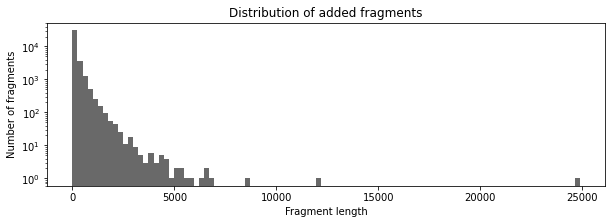

In [23]:
# Calculate distribution of new fragments
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

ax.set_ylabel('Number of fragments')
ax.set_yscale('log')
# ax.set_xscale('log')

hist = ax.hist(newdata['length'], bins=100, color='dimgrey')

plt.title('Distribution of added fragments')
plt.xlabel('Fragment length')
plt.show()

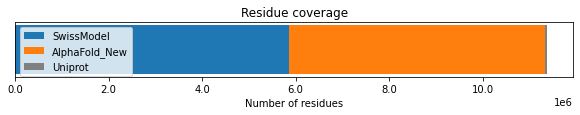

In [24]:
fig, ax = plt.subplots()

fig.set_size_inches(10, 1)
ax.axes.yaxis.set_visible(False)

# format axes from https://stackoverflow.com/questions/43324152/python-matplotlib-colorbar-scientific-notation-base
class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

# ax.set_xlim(0, 12 * 10**6)
ax.barh(0, smtotal, label='SwissModel')
ax.barh(0, afnewtotal, left=smtotal, label='AlphaFold_New')
ax.barh(0, unresolved, left=smtotal + afnewtotal, color='grey', label='Uniprot')

ax.tick_params(
    axis='y',
    top=None)

ax.xaxis.set_major_formatter(OOMFormatter(6, mathText=False))

ax.set_title('Residue coverage')
ax.set_xlabel('Number of residues')
ax.legend()
plt.show()

In [26]:
# Collect all individual pLDDT values into one array
plddtall_ = list()
for index, row in newdata.iterrows():
    plddtall_.extend(row['pLDDT'])
plddtall = np.array(plddtall_)

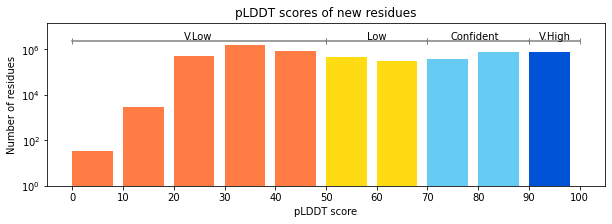

In [35]:
scoreticks = np.linspace(0, 100, 11)

plt.figure(figsize=(10, 3))

plt.ylabel('Number of residues')
plt.xlabel('pLDDT score')
plt.yscale('log')

N, bins, patches = plt.hist(plddtall, bins=scoreticks, width=8)

# Color distibution according to AlphaFold colors
cvlow = '#ff7d45'
clow = '#ffdb13'
cconf = '#65cbf3'
cvhigh = '#0053d6'

for i in range(5):
    patches[i].set_facecolor(cvlow)
for i in range(5, 7):
    patches[i].set_facecolor(clow)
for i in range(7, 9):
    patches[i].set_facecolor(cconf)
for i in range(9, 10):
    patches[i].set_facecolor(cvhigh)
    
maxy = np.max(N)
plt.xticks(scoreticks)
plt.title('')
plt.plot((0, 50), (maxy * 1.5, maxy * 1.5), marker='|', c='grey')
plt.text(22, maxy * 1.8, 'V.Low')
plt.plot((50, 70), (maxy * 1.5, maxy * 1.5), marker='|', c='grey')
plt.text(58, maxy * 1.8, 'Low')
plt.plot((70, 90), (maxy * 1.5, maxy * 1.5), marker='|', c='grey')
plt.text(74.5, maxy * 1.8, 'Confident')
plt.plot((90, 100), (maxy * 1.5, maxy * 1.5), marker='|', c='grey')
plt.text(92, maxy * 1.8, 'V.High')
plt.ylim((1, maxy * 10.0))
# plt.xlim(0, 100)
plt.title('pLDDT scores of new residues')
plt.show()

In [36]:
plddtall_conf = len(plddtall[plddtall > 70])
print('Total new confident residues: %d' % plddtall_conf)
print('Total new residues in AlphaFold (aa): %d' % afnewtotal)
print('Confindent residues/Total new residues: %.2f%%' % (plddtall_conf / afnewtotal * 100.0))

Total new confident residues: 1875653
Total new residues in AlphaFold (aa): 5479287
Confindent residues/Total new residues: 34.23%


In [37]:
# Calculater individual pLDDT distribution per aminoacid type

aas = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

plddtaa_ = dict([(aa, []) for aa in aas])
plddtaanew_ = dict([(aa, []) for aa in aas])

for index, row in afdata.iterrows():
    plddt = row['pLDDT']
    seq = row['sequence']
    for i in range(row['length']):
        aa = seq[i]
        plddt_ = plddt[i]
        plddtaa_[aa].append(plddt_)

for index, row in newdata.iterrows():
    plddt = row['pLDDT']
    seq = row['sequence']
    for i in range(row['length']):
        aa = seq[i]
        plddt_ = plddt[i]
        plddtaanew_[aa].append(plddt_)

plddtaa = np.zeros((10, len(aas)))
for i in range(len(aas)):
    aa = aas[i]
    bins, edges = np.histogram(plddtaa_[aa], bins=scoreticks)
    bins_ = np.array(bins) / np.sum(bins)
    plddtaa[:, i] = bins_[:]

plddtaanew = np.zeros((10, len(aas)))
for i in range(len(aas)):
    aa = aas[i]
    bins, edges = np.histogram(plddtaanew_[aa], bins=scoreticks)
    bins_ = np.array(bins) / np.sum(bins)
    plddtaanew[:, i] = bins_[:]
    
plddtaadiff = plddtaa - plddtaanew

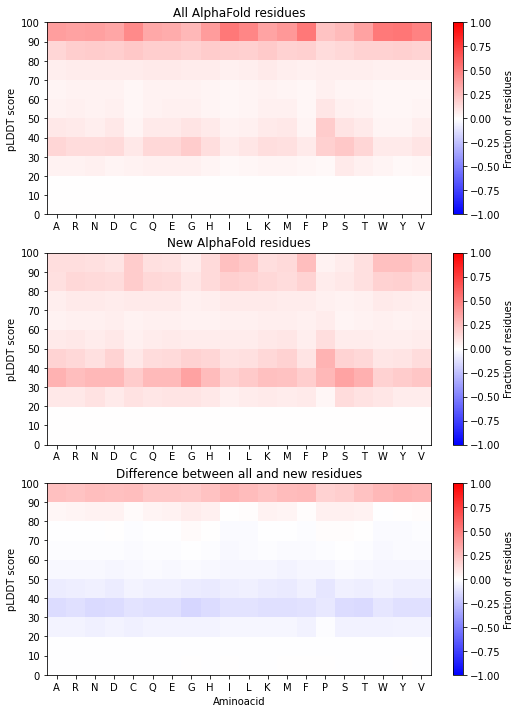

In [40]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1)

fig.set_size_inches((10, 12))

im0 = ax0.imshow(plddtaa, cmap='bwr', origin='lower', vmin=-1, vmax=1)
# ax0.set_xlabel('Aminoacid')
ax0.set_title('All AlphaFold residues')
ax0.set_xticks(np.arange(0, 20))
ax0.set_xticklabels(aas)
ax0.set_ylabel('pLDDT score')
ax0.set_yticks(np.arange(-0.5, 10.5))
ax0.set_yticklabels(scoreticks.astype(int))
cbar0 = fig.colorbar(im0, fraction=0.0235, pad=0.04, ax=ax0)
cbar0.set_label('Fraction of residues')

im1 = ax1.imshow(plddtaanew, cmap='bwr', origin='lower', vmin=-1, vmax=1)
ax1.set_title('New AlphaFold residues')
# ax1.set_xlabel('Aminoacid')
ax1.set_xticks(np.arange(0, 20))
ax1.set_xticklabels(aas)
ax1.set_ylabel('pLDDT score')
ax1.set_yticks(np.arange(-0.5, 10.5))
ax1.set_yticklabels(scoreticks.astype(int))
cbar1 = fig.colorbar(im1, fraction=0.0235, pad=0.04, ax=ax1)
cbar1.set_label('Fraction of residues')

im2 = ax2.imshow(plddtaadiff, cmap='bwr', origin='lower', vmin=-1, vmax=1)
ax2.set_title('Difference between all and new residues')
ax2.set_xlabel('Aminoacid')
ax2.set_xticks(np.arange(0, 20))
ax2.set_xticklabels(aas)
ax2.set_ylabel('pLDDT score')
ax2.set_yticks(np.arange(-0.5, 10.5))
ax2.set_yticklabels(scoreticks.astype(int))
cbar2 = fig.colorbar(im2, fraction=0.0235, pad=0.04, ax=ax2)
cbar2.set_label('Fraction of residues')

plt.show()

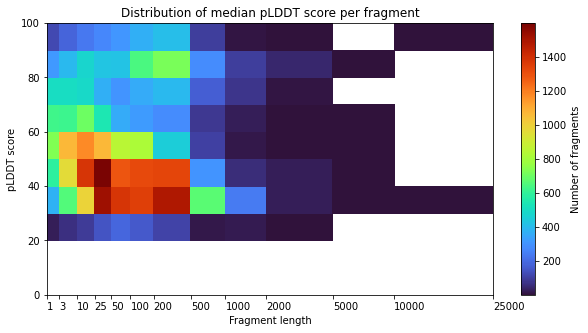

In [52]:
# Scale axis as in https://matplotlib.org/stable/gallery/scales/scales.html

# Function x**(1/2)
def forward(x):
    return x**(1/4)

def inverse(x):
    return x**4

xticks = [1, 3, 10, 25, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 25000]
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

ax.set_xscale('function', functions=(forward, inverse))

hist = ax.hist2d(
    newdata['length'], 
    newdata['pLDDT_med'], 
    cmap='turbo', cmin=1,
    bins=[xticks, np.linspace(0, 100, 11)])
# ax.set_xscale('log')
cb = fig.colorbar(hist[3], ax=ax)
cb.set_label('Number of fragments')
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, rotation=0, verticalalignment='top', horizontalalignment='left')
ax.set_ylabel('pLDDT score')
ax.set_xlabel('Fragment length')
ax.set_title('Distribution of median pLDDT score per fragment')
plt.show()

In [60]:
# Look if there any domain-level enrichment in new fragments

frags_ = newdata[(newdata['length'] >= 100) &
                 (newdata['length'] < 500) &
                 (newdata['pLDDT_med'] > 70)
                ]

fragdomains_ = list()

for index, row in tqdm.tqdm(frags_.iterrows(), total=len(frags_)):
    ac = row['uniprot_ac']
    udata_ = udata[udata['Entry'] == ac]
    b = row['from']
    e = row['to']
    udomains = udata_['Domain [FT]'].values[0]
    
    if type(udomains) is not str:
        continue
    
    # Look for annotated domains from the Uniprot data
    domains_ = udomains.split(';')
    for i in range(len(domains_)):
        v = domains_[i]
        if v[:6] == 'DOMAIN':
            v_ = v.split(' ')[1]
            be_ = v_.split("..")
            b_ = int(re.sub("[^0-9]", '', be_[0]))
            e_ = int(re.sub("[^0-9]", '', be_[1]))

            flag = False
            if b_ <= b and e_ >= b:
                flag = True
            elif b_ <= e and e_ >= e:
                flag = True
            elif b_ >= b and e_ <= e:
                flag = True

            if flag is True:
                domain_ = domains_[i + 1].strip()
                domain_ = re.sub('"', '', domain_)
                domain_ = re.sub('/note=', '', domain_)

                d_ = {
                    'ac': ac,
                    'from': b,
                    'to': e,
                    'domain': domain_,
                    'from_d': b_,
                    'to_d': e_,
                    'pLDDT_med': row['pLDDT_med'],
                    'sequence': row['sequence']
                }
                fragdomains_.append(d_)
    
fragdomains = pd.DataFrame(fragdomains_)

100%|██████████| 2901/2901 [00:03<00:00, 900.04it/s]


In [61]:
# Count actual counts
fragdomainsc_ = Counter(fragdomains['domain'])
fragdomainsc = pd.DataFrame(fragdomainsc_.items(), columns=['Name', 'Count'])
fragdomainsc = fragdomainsc.sort_values(by='Count', ascending=False)

In [63]:
fragdomainsc

,Name,Count
18,Ig-like C2-type 1,11
17,BTB,10
16,EGF-like 1,10
1,LRRCT,10
87,TLC,10
...,...,...
143,CRIB,1
51,PDEase,1
141,SAM-dependent MTase TRM10-type,1
140,DDE Tnp4,1


In [72]:
# Save all the data
# Uniprot
udata.to_csv('/tmp/uniprot_31072021.csv')
# SwissModel Repository
smdata.to_csv('/tmp/swissmodel_31072021.csv')
# AlphaFold
afdata.to_csv('/tmp/alphafold_31072021.csv')
# New fragments
newdata.to_csv('/tmp/newdata_31072021.csv')
# Domain counts
fragdomainsc.to_csv('/tmp/domains_31072021.csv')